In [2]:
import sklearn
import matplotlib.pyplot as plt
from generate_data import *


def plot_lines(xy, label):
    lines = [g[1] for g in df.groupby("line", group_keys=False)]
    plt.figure(figsize=(20, 10))
    alpha = 2 / np.sqrt(len(lines))
    for line in reversed(lines):  # draw easier first / on top
        x,y = xy[line.index].T
        marker = MARKERS[line["algo"].iloc[0]]
        color = COLORS[line["algo"].iloc[0]]
        plt.plot(x, y, marker=marker, markersize=10, markevery=[0,-1], c=color, alpha=alpha, linewidth=1)
        plt.legend([label + " " + DATA_NAME])
    # plt.margins(0.01)
    plt.show()

df = pd.read_csv("trace10_4.csv")
df

x   y                 line               algo  step  reward  zeros  \
0          4  14             random-0             random     0       4     14   
1          4  13             random-0             random     1       4     13   
2          4  12             random-0             random     2       4     12   
3          8  12             random-0             random     3       8     12   
4         16  12             random-0             random     4      16     12   
...      ...  ..                  ...                ...   ...     ...    ...   
20248  14900   0  lookahead-3-zeros-9  lookahead-3-zeros   871   14900      0   
20249  14904   0  lookahead-3-zeros-9  lookahead-3-zeros   872   14904      0   
20250  14912   0  lookahead-3-zeros-9  lookahead-3-zeros   873   14912      0   
20251  14932   1  lookahead-3-zeros-9  lookahead-3-zeros   874   14932      1   
20252  14932   0  lookahead-3-zeros-9  lookahead-3-zeros   875   14932      0   

        sum  biggest  a0  ...  cnt4  cnt8  cnt16  cnt32  cnt64  cnt128  \
0         6        4   4  ...     1     0      0      0      0       0   
1         8        4   0  ...     1     0      0      0      0       0   
2        10        4   0  ...     1     0      0      0      0       0   
3        12        4   0  ...     2     0      0      0      0       0   
4        16        8   0  ...     1     1      0      0      0       0   
...     ...      ...  ..  ...   ...   ...    ...    ...    ...     ...   
20248  1924     1024   4  ...     1     3      2      2      0       2   
20249  1928     1024   4  ...     3     3      2      2      0       2   
20250  1930     1024   4  ...     1     4      2      2      0       2   
20251  1932     1024   4  ...     2     2      3      2      0       2   
20252  1934     1024   4  ...     2     2      3      2      0       2   

       cnt256  cnt512  cnt1024  cnt2048  
0           0       0        0        0  
1           0       0        0        0  
2           0       0        0        0  
3           0       0        0        0  
4           0       0        0        0  
...       ...     ...      ...      ...  
20248       0       1        1        0  
20249       0       1        1        0  
20250       0       1        1        0  
20251       0       1        1        0  
20252       0       1        1        0  

[20253 rows x 37 columns]

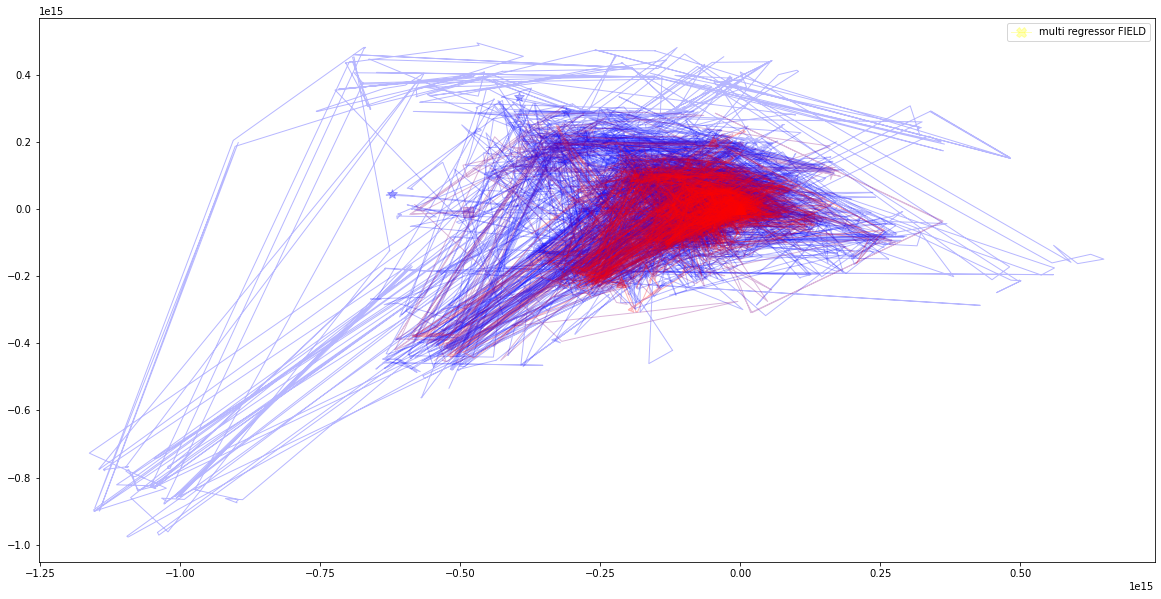

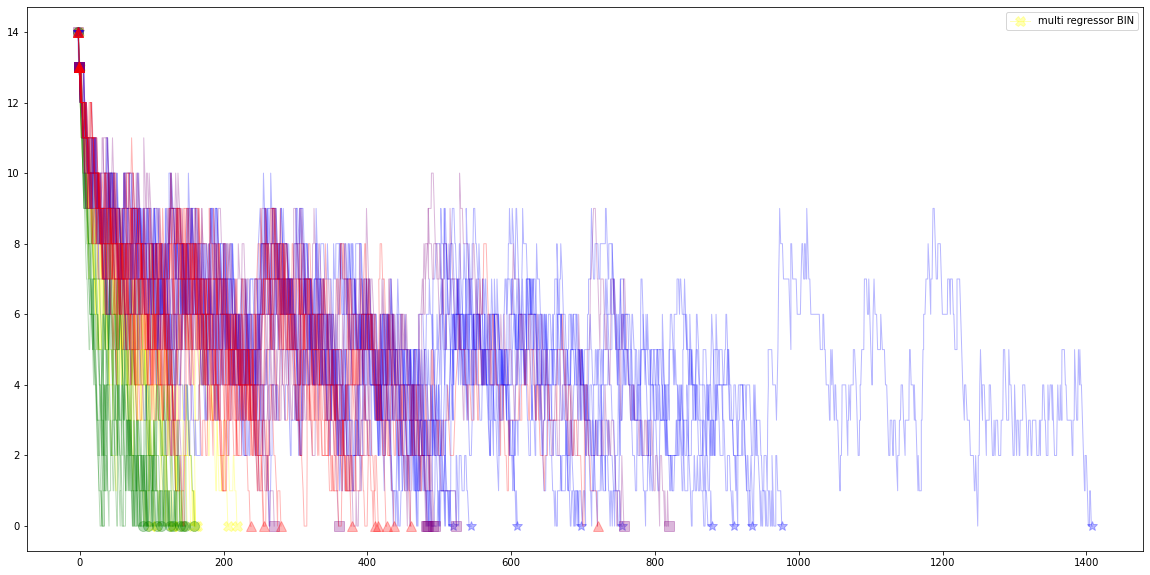

In [4]:
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor

# supervised: fit field or bins to step + zeros + 
for DATA_NAME, DATA in (("FIELD", FIELD_), ("BIN", BIN_)):
    xy = df[DATA].to_numpy()
    
    sgd = MultiOutputRegressor(SGDRegressor())
    sgd.fit(xy, df[["step", "zeros"]]) # "reward", "biggest", "sum"
    xy = sgd.predict(xy)
    
    plot_lines(xy, "multi regressor")

In [5]:
"""
Theoretical concepts: https://i-systems.github.io/teaching/ML/iNotes/15_Autoencoder.html
Instead of manually building the 2-part-encoder, we can just "chop off the head" of a neural network at any 
layer by setting the n_layers_ to a specific number, due to it not iterating over layers, but range(n_layers)

"""

LAB = ["step", "zeros", "sum", "biggest"] + FIELD_
# LAB = ["step", "zeros"] + BIN_

xy = df[LAB].to_numpy()

"""
Sadly this is REALLY slow for 4x4 data, so I tried using pytorch

print(len(DATA), len(xy))

NR_FEAT = len(df) - 2margins
mlp = MLPRegressor(hidden_layer_sizes=(NR_FEAT, 2, NR_FEAT), 
                   solver = 'adam', # sgd, adam, 
                   activation="identity",
                   learning_rate_init = 0.001, 
                   learning_rate = "adaptive")
# mlp.loss = "log_loss" # didn't really help the encoding too much

mlp.fit(xy, xy)
xy = df[LAB].to_numpy()
mlp.n_layers_ = mlp.hidden_layer_sizes.index(2)+2  # index of the 2-layer
pred = mlp.predict(xy)
print(pred.shape)

plot_lines(pred, DATA_NAME)
""";

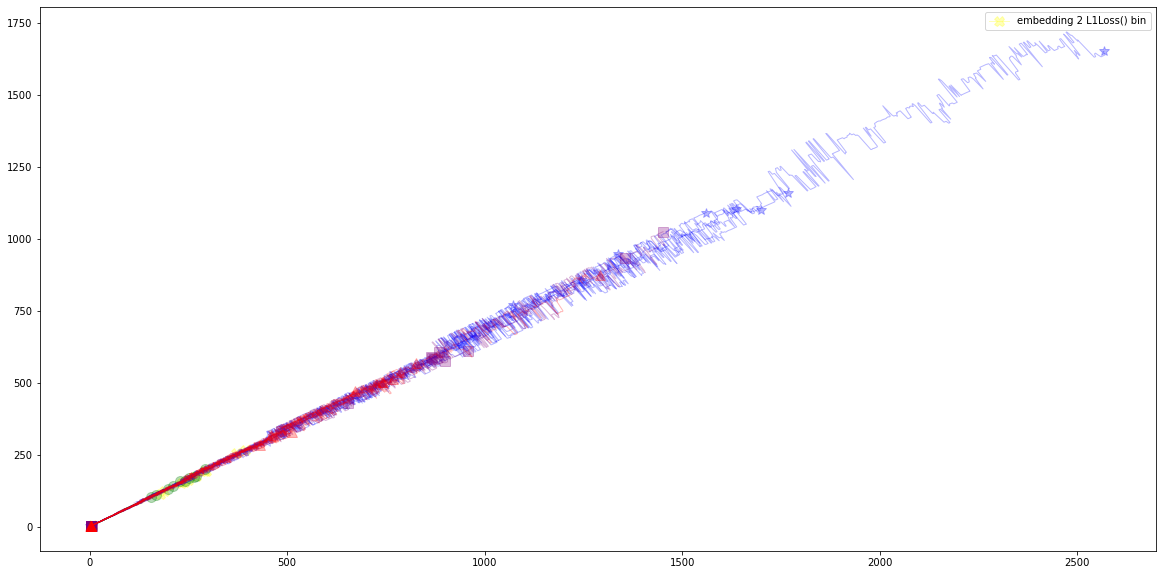

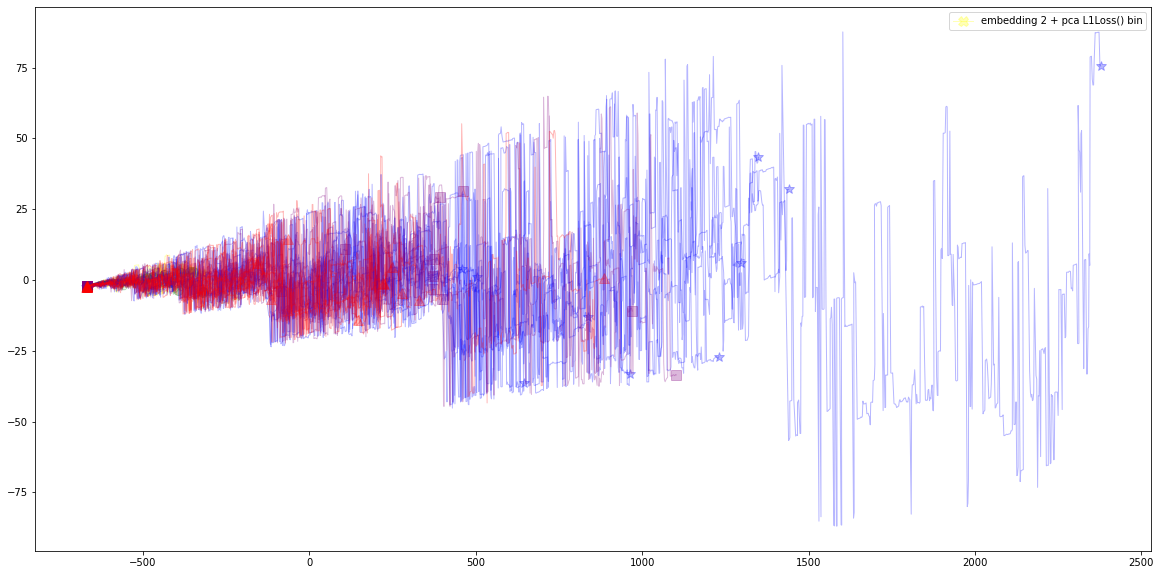

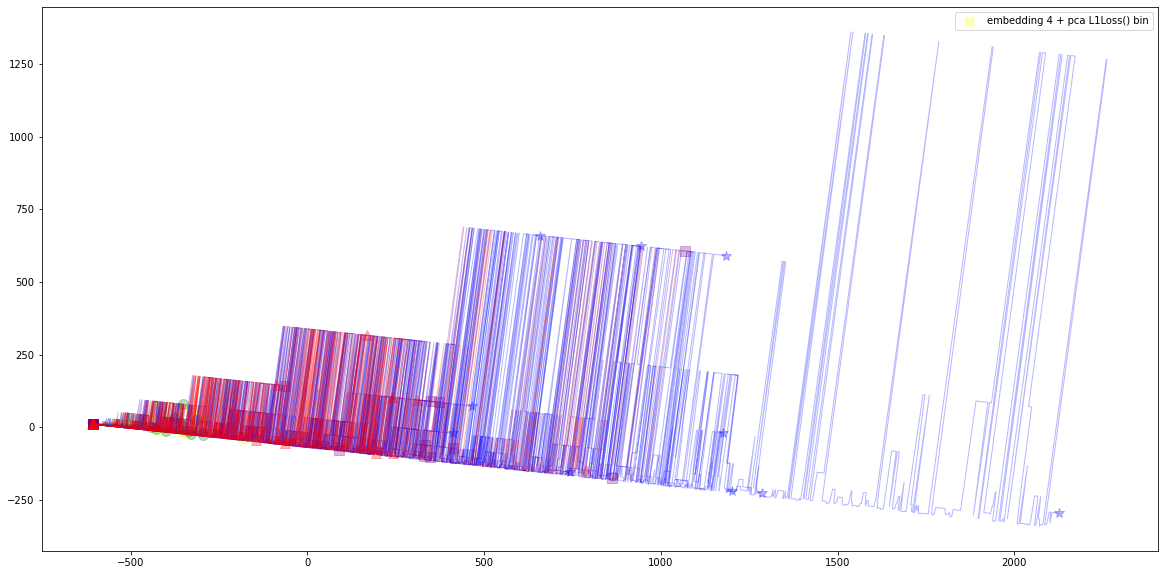

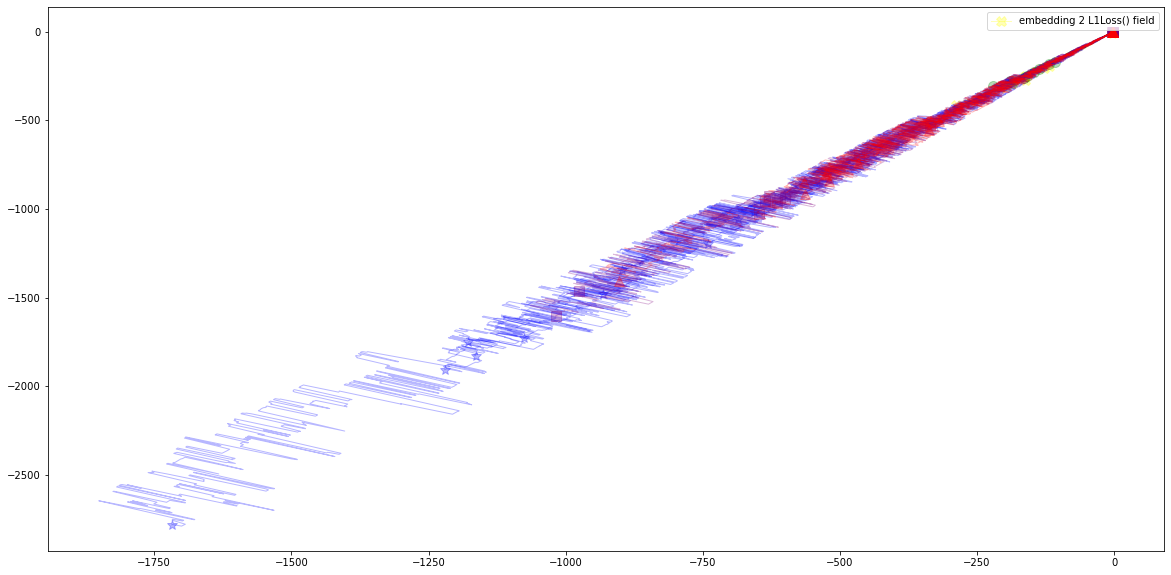

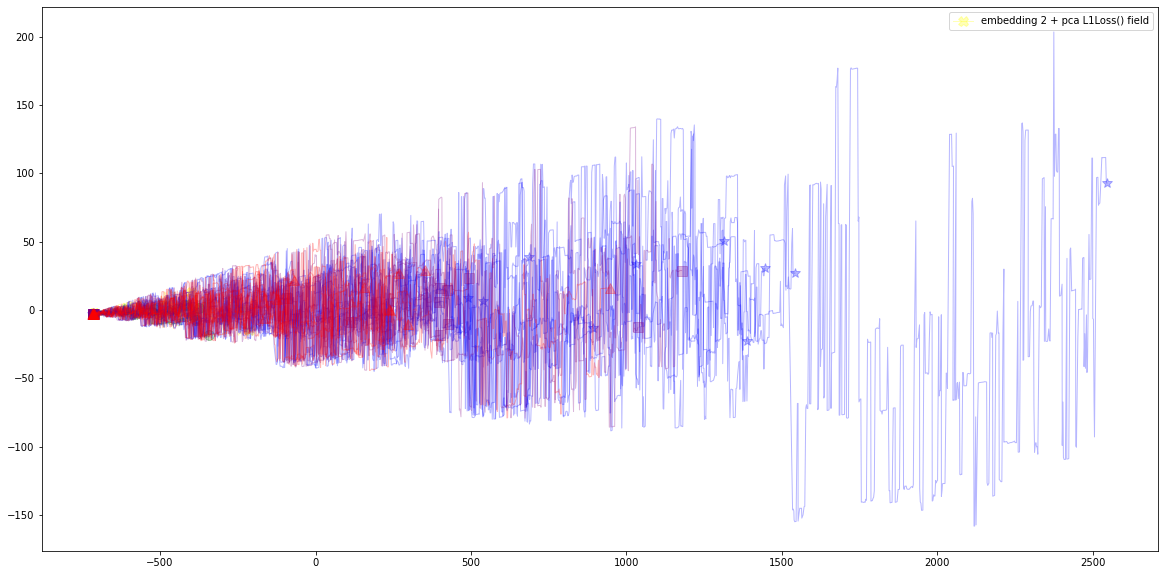

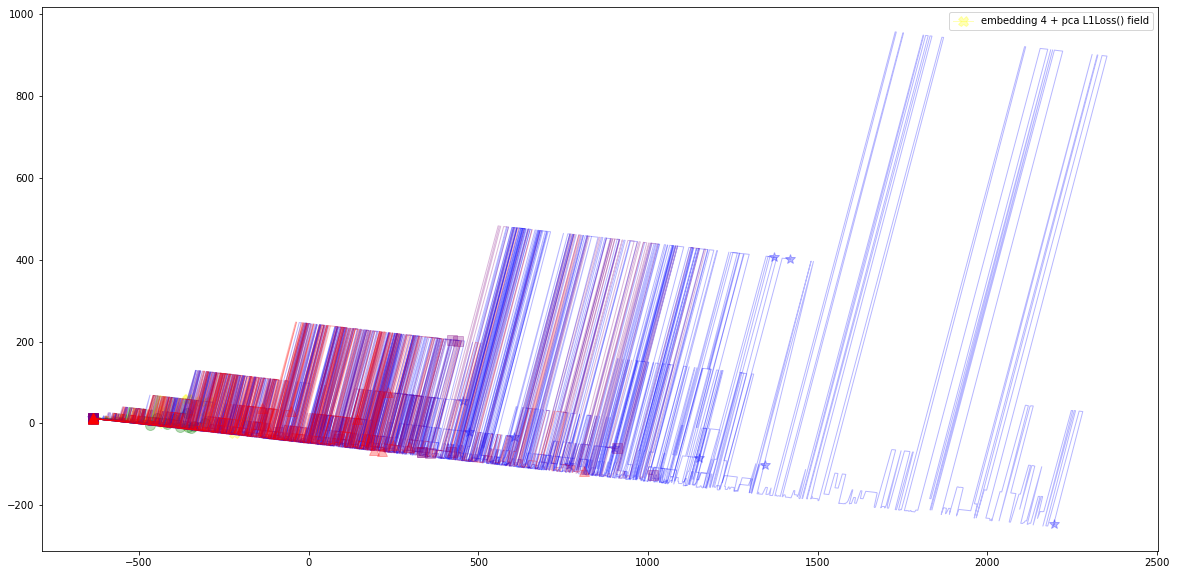

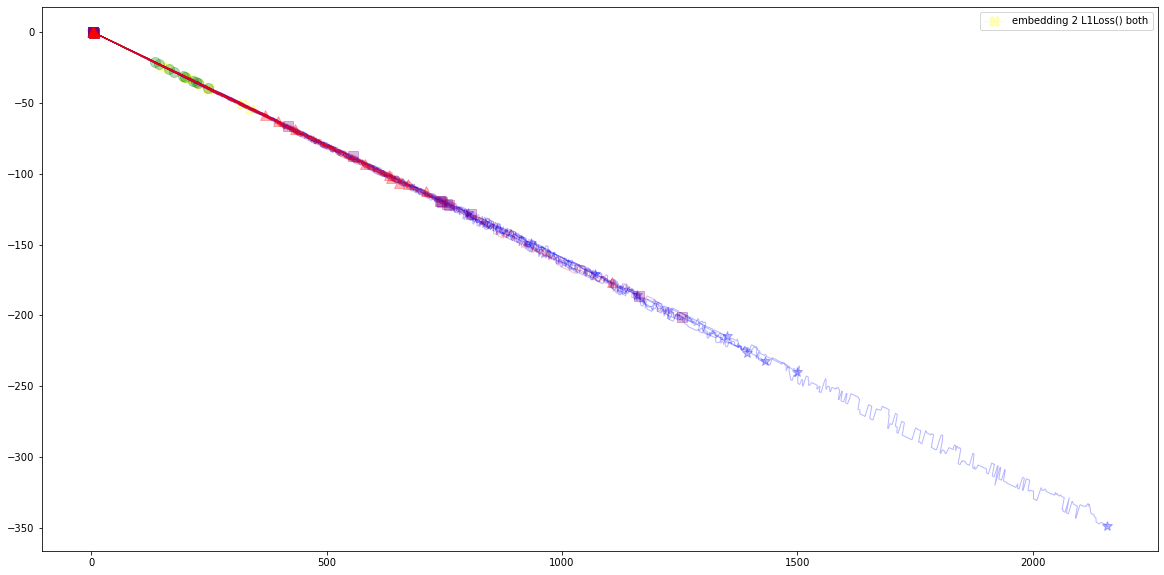

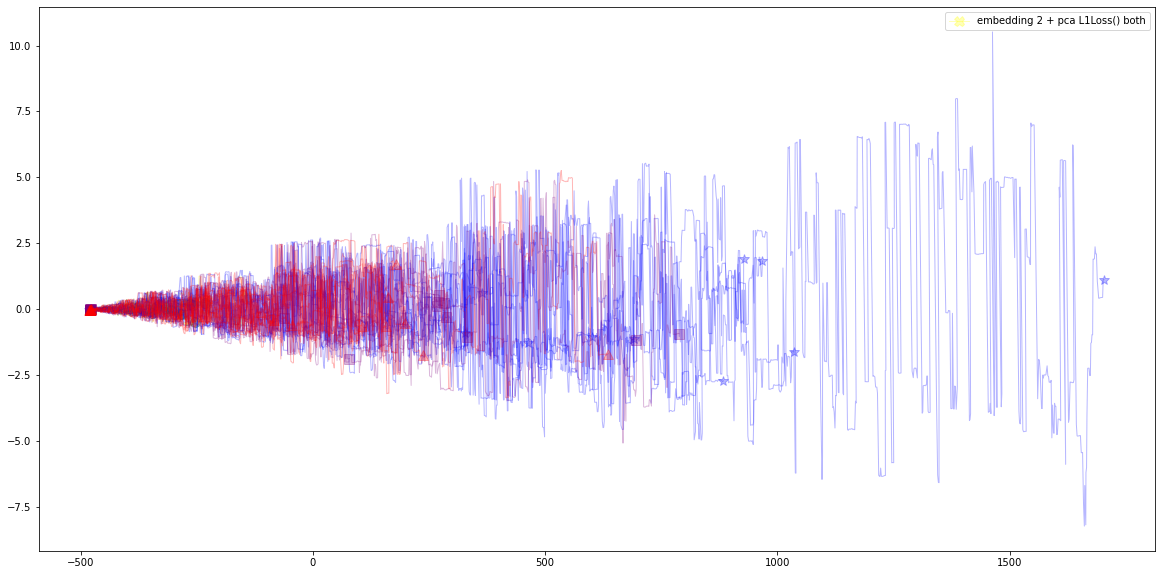

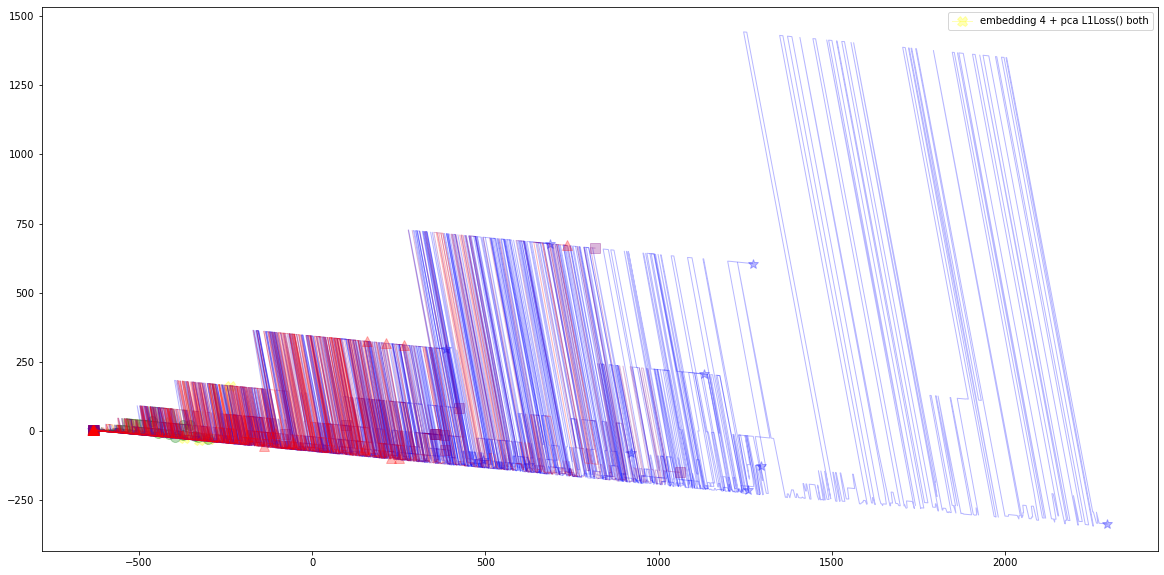

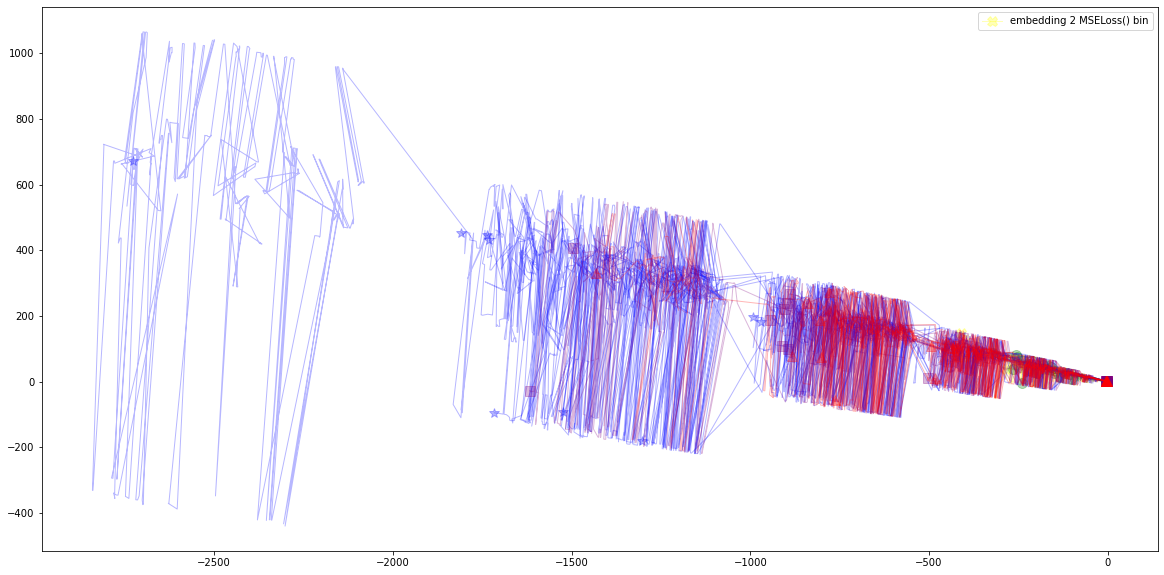

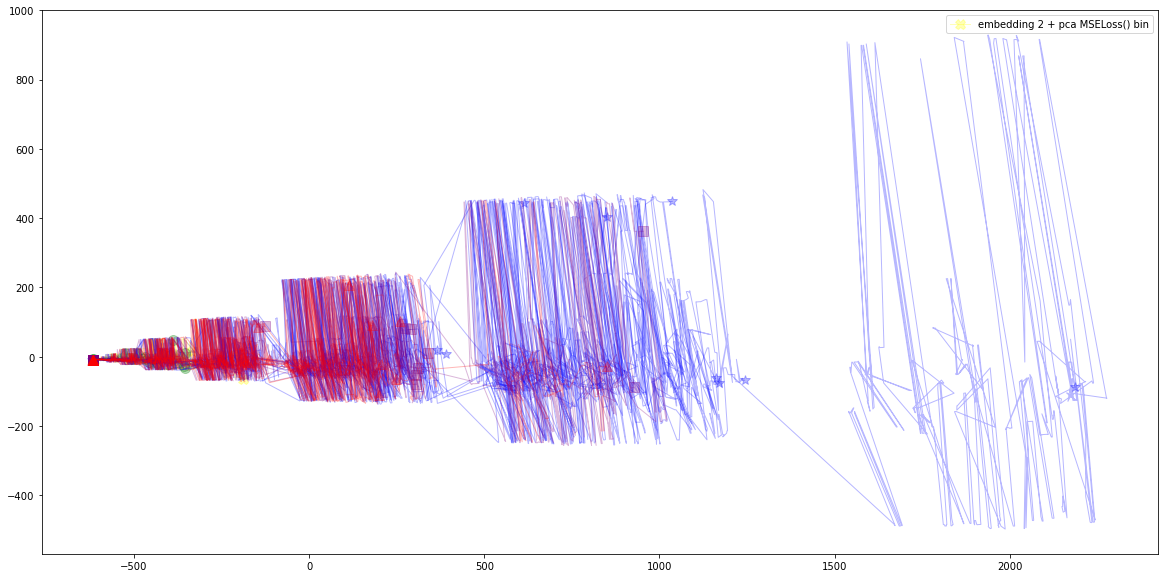

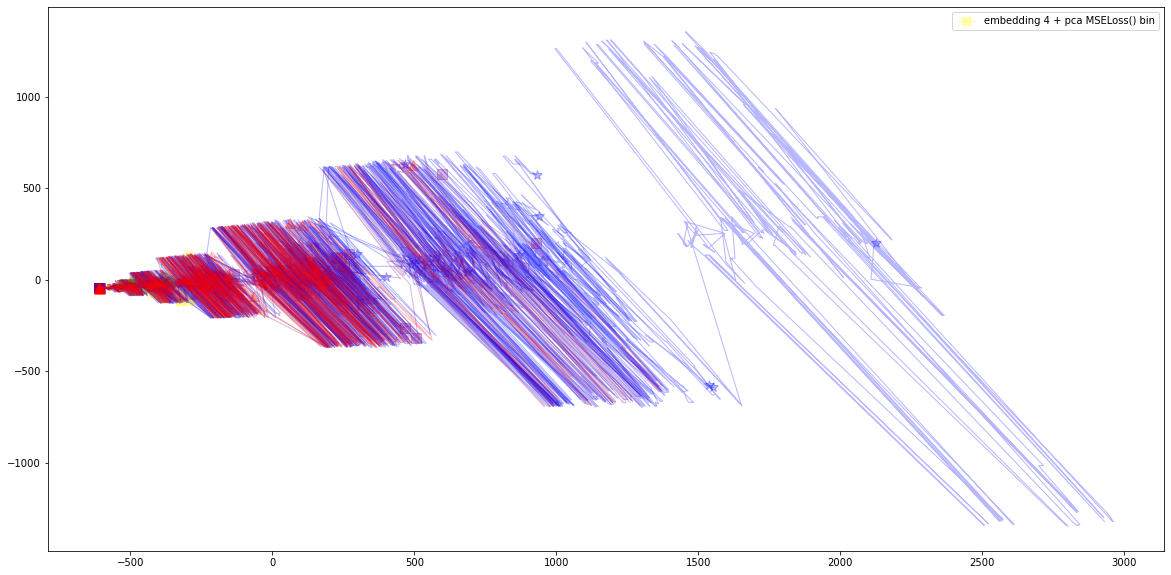

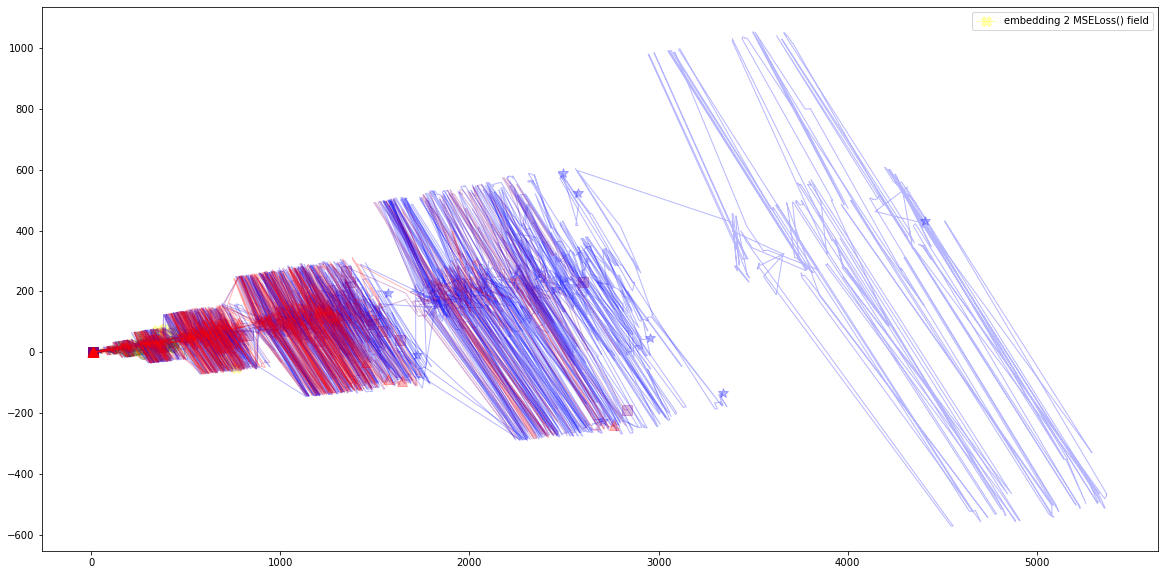

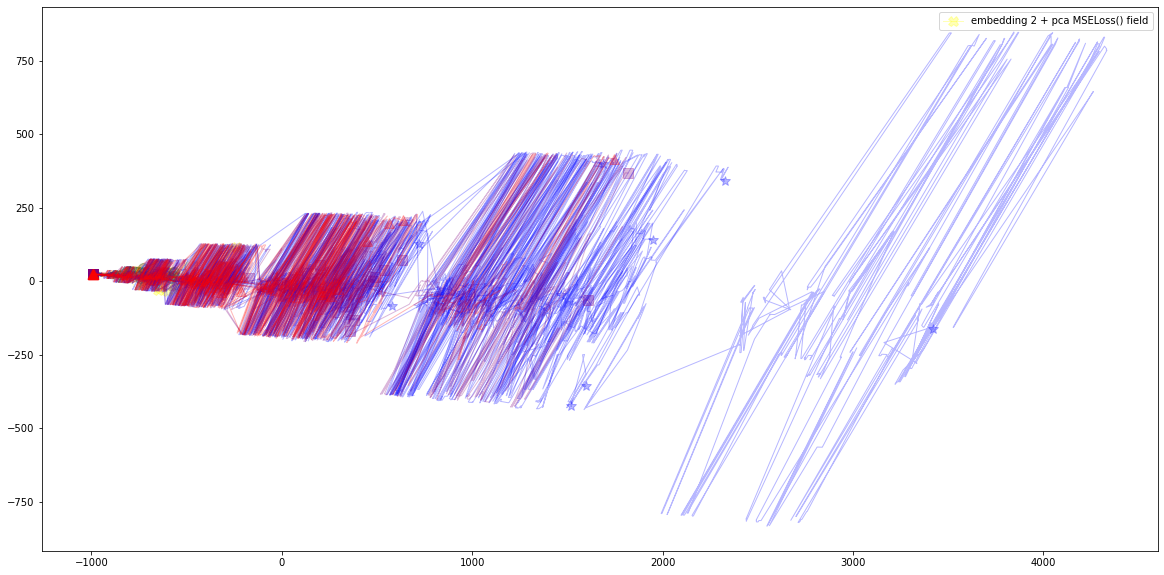

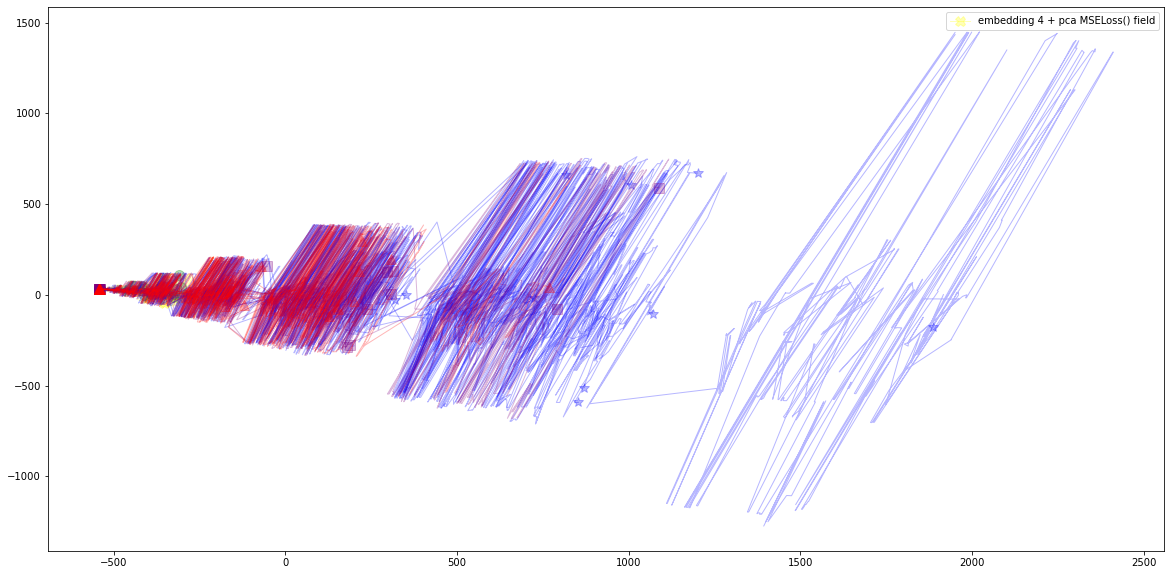

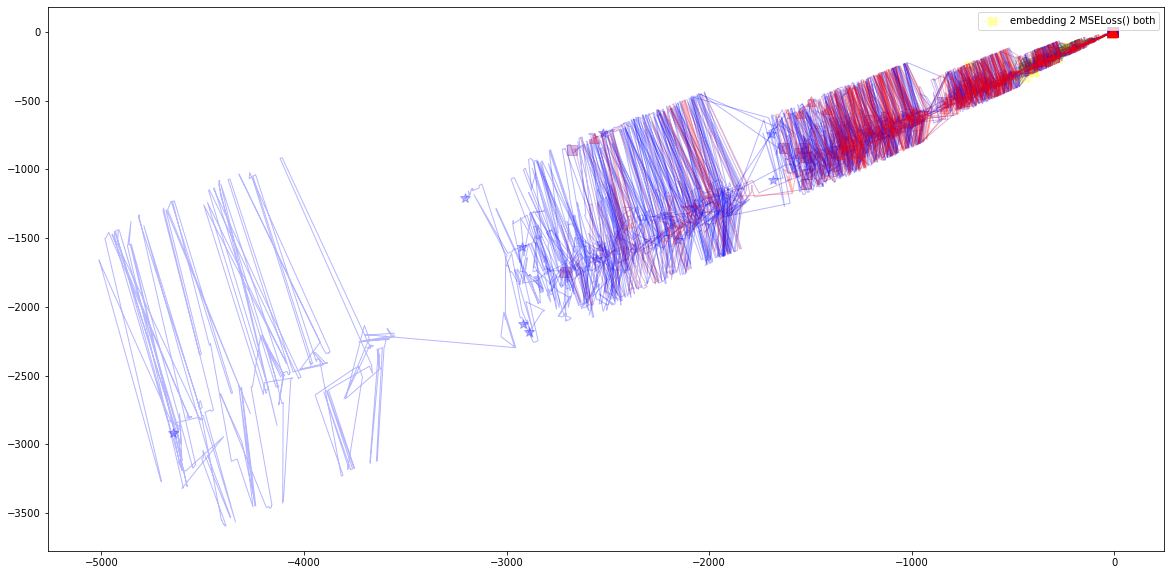

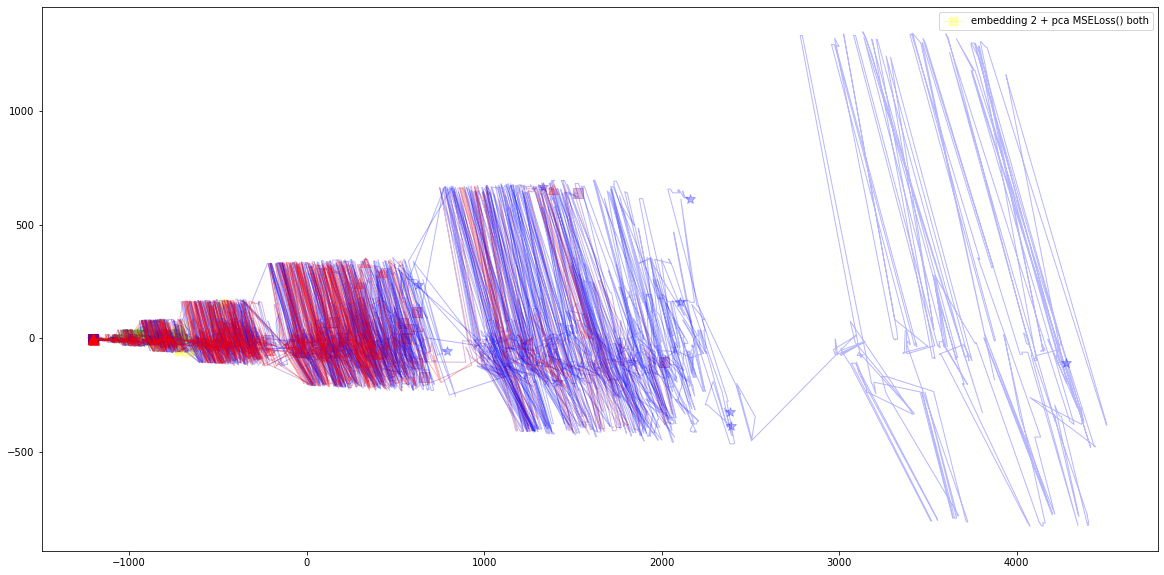

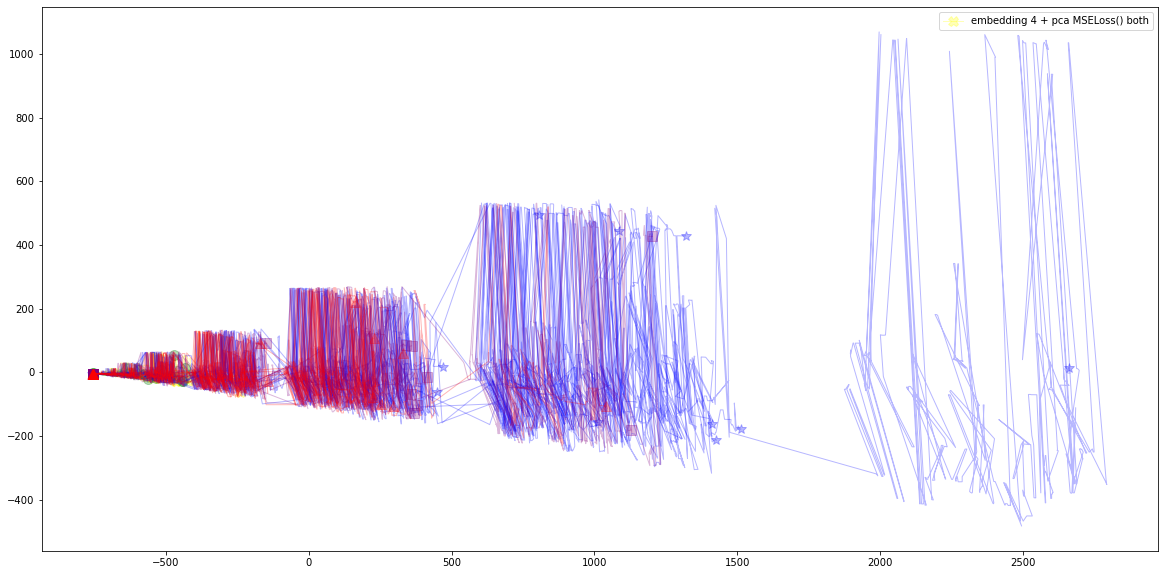

In [8]:
import torch.optim as optim
import torch.nn as nn
import torch
from sklearn.decomposition import PCA


def embed(xy, n_hidden = 20, n_hidden2 = 2, criterion = nn.L1Loss(), batch_size = 2**14, device="cuda", max_iter = 10000,
          lr=0.001, early_stop_tresh=1.001, verbose=True):
    """ Autoencoder with 2 layers """
    l0 = nn.Linear(len(xy[0]), n_hidden) # bias=False
    l1 = nn.Linear(n_hidden, n_hidden2) # bias=False
    l2 = nn.Linear(n_hidden2, n_hidden) # bias=False
    l3 = nn.Linear(n_hidden, len(xy[0])) # bias=False
    
    encoder = nn.Sequential(l0, l1)
    decoder = nn.Sequential(l2, l3)
    net = nn.Sequential(encoder, decoder)
    
    if verbose:
        print(l0, l1)

    # optimizer = optim.SGD(params=net.parameters(), lr=lr)
    optimizer = optim.Adam(params=net.parameters(), lr=lr)
    
    inputs = torch.Tensor(xy).to(device)
    net.to(device)

    running_losses = [1e10]
    for epoch in range(max_iter):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(0, len(xy), batch_size):
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            inp = inputs[i:i+batch_size]
            outputs = net(inp)
            loss = criterion(outputs, inp)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        running_losses.append(running_loss)

        if not epoch % 100:
            if verbose:
                print(epoch, running_loss)
            best = net.state_dict()
            # early stopping: if the improvement is less than 0.1%
            if max(running_losses[-100:]) <= running_loss * early_stop_tresh:
                if verbose:
                    print("early stopping")
                break
    
    net.load_state_dict(best)
    return encoder(inputs).to("cpu").detach().numpy()

BASE = ["step", "zeros", "sum", "biggest"]
for loss in [nn.L1Loss() , nn.MSELoss()]:
    for DATA_NAME, lab in {"bin": BASE + BIN_, "field": BASE + BIN_, "both": BASE + BIN_ + FIELD_}.items():
        xy = xy = df[LAB].to_numpy()

        embedding_2 = embed(xy, n_hidden=2, verbose=False, criterion=loss)
        plot_lines(embedding_2, f"embedding 2 {loss}")

        embedding_2_pca = PCA(n_components=2).fit_transform(embedding_2)
        plot_lines(embedding_2_pca, f"embedding 2 + pca {loss}")

        embedding_4 = embed(xy, n_hidden=4, verbose=False, criterion=loss)
        embedding_4_pca = PCA(n_components=2).fit_transform(embedding_4)
        plot_lines(embedding_4_pca, f"embedding 4 + pca {loss}")